# <center> Depth of Customer Relationship </center>
#    <center> Using Recency, Frequency and Monetary Value </center>


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('OnlineRetail.csv',encoding='unicode-escape')

In [3]:
data.head(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.describe

<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

            InvoiceDate  UnitPrice  Custo

In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
#let's drop rows with NaN customer IDs
#we'll use notna() to keep rows that have a customer ID
#During our EDA class, we assumed that these customers are those who do guest checkout online

data = data[data.CustomerID.notna()]

In [8]:
#create SaleValue column as Quantity * UnitPrice

data['SaleValue'] = data.Quantity * data.UnitPrice
data.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [9]:
#convert InvoiceDate to datetime type
#we're doing this so that we can subtract dates properly

data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   SaleValue    406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [10]:
#drop decimals in customer ID and change data type to string
data['CustomerID'] = data.CustomerID.astype('Int64').astype(str)

## Calculate Recency

We'll use the max date on the dataset to calculate recency of each customer purchase.

In [11]:
#what is the most recent date in the entire data set
#we're going to use this to calculate recency for all customers

data.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [12]:
#group customer IDs by their most recent purchases
data.groupby('CustomerID').InvoiceDate.max()

CustomerID
12346   2011-01-18 10:17:00
12347   2011-12-07 15:52:00
12348   2011-09-25 13:13:00
12349   2011-11-21 09:51:00
12350   2011-02-02 16:01:00
                ...        
18280   2011-03-07 09:52:00
18281   2011-06-12 10:53:00
18282   2011-12-02 11:43:00
18283   2011-12-06 12:02:00
18287   2011-10-28 09:29:00
Name: InvoiceDate, Length: 4372, dtype: datetime64[ns]

In [13]:
data.groupby('CustomerID').InvoiceDate.max().tail()

CustomerID
18280   2011-03-07 09:52:00
18281   2011-06-12 10:53:00
18282   2011-12-02 11:43:00
18283   2011-12-06 12:02:00
18287   2011-10-28 09:29:00
Name: InvoiceDate, dtype: datetime64[ns]

In [14]:
#grouping InvoiceDates by CustomerID
data.groupby('InvoiceDate').CustomerID.max()

InvoiceDate
2010-12-01 08:26:00    17850
2010-12-01 08:28:00    17850
2010-12-01 08:34:00    13047
2010-12-01 08:35:00    13047
2010-12-01 08:45:00    12583
                       ...  
2011-12-09 12:23:00    13777
2011-12-09 12:25:00    13777
2011-12-09 12:31:00    15804
2011-12-09 12:49:00    13113
2011-12-09 12:50:00    12680
Name: CustomerID, Length: 20460, dtype: object

In [15]:
#create a data frame with this recency information
#create a series for recency

recency = data.groupby('CustomerID').InvoiceDate.max()
recency.head(8)

CustomerID
12346   2011-01-18 10:17:00
12347   2011-12-07 15:52:00
12348   2011-09-25 13:13:00
12349   2011-11-21 09:51:00
12350   2011-02-02 16:01:00
12352   2011-11-03 14:37:00
12353   2011-05-19 17:47:00
12354   2011-04-21 13:11:00
Name: InvoiceDate, dtype: datetime64[ns]

In [16]:
#calculate recency days by substracting each date from the max purchase date in the dataset

recency = recency-data.InvoiceDate.max()

#view top rows to see what you've done
#we're using these negatives so that during clustering, lower numbers will have lower scores
recency.head()

CustomerID
12346   -326 days +21:27:00
12347     -2 days +03:02:00
12348    -75 days +00:23:00
12349    -19 days +21:01:00
12350   -310 days +03:11:00
Name: InvoiceDate, dtype: timedelta64[ns]

In [17]:
#extract only number of days portion from recency values

recency = recency.dt.days

#view top rows to see what you've done
recency.head(8)

CustomerID
12346   -326
12347     -2
12348    -75
12349    -19
12350   -310
12352    -36
12353   -204
12354   -232
Name: InvoiceDate, dtype: int64

In [18]:
#rename series to recency so that we can use that name as a column name for the RFM DataFrame we will create

#your code here. name it 'Recency'

recency.name='Recency'


In [19]:
#create a new DataFrame using the recency series for a starting point
RFM = pd.DataFrame(recency)

#check what you've created
RFM.head(7)

,Recency
CustomerID,
12346,-326
12347,-2
12348,-75
12349,-19
12350,-310
12352,-36
12353,-204


In [20]:
#pop out CustomerID to become a column. 
#we don't want it to be an index because we'll play with indexes during clustering
RFM.reset_index(inplace=True)
RFM.head(10)

,CustomerID,Recency
0,12346,-326
1,12347,-2
2,12348,-75
3,12349,-19
4,12350,-310
5,12352,-36
6,12353,-204
7,12354,-232
8,12355,-214
9,12356,-23


In [21]:
# View summary statistics 
RFM.describe()

,Recency
count,4372.000000
mean,-92.043001
std,100.765435
min,-374.000000
25%,-143.000000
50%,-50.000000
75%,-17.000000
max,0.000000


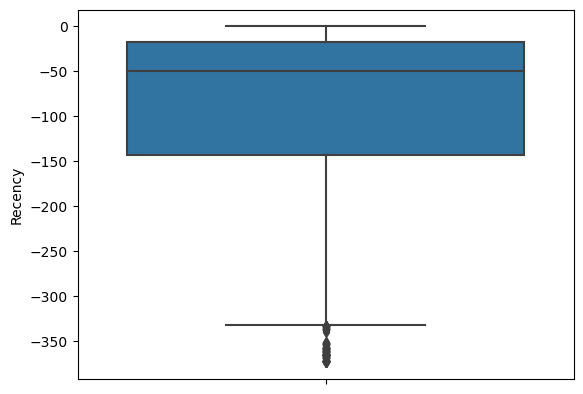

In [22]:
sns.boxplot(y='Recency',data=RFM)

plt.show()

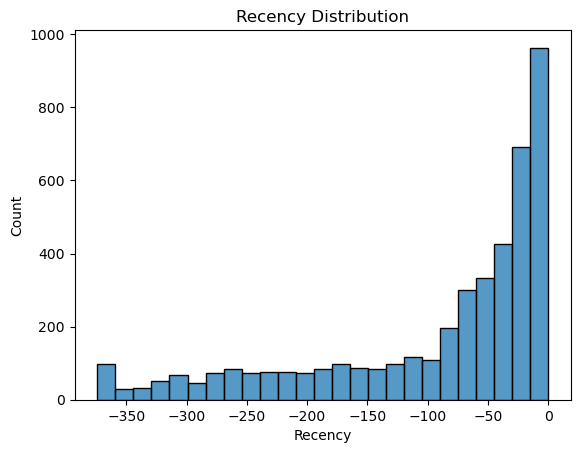

In [23]:
sns.histplot(data=RFM['Recency'])
plt.title('Recency Distribution')

plt.show()

## Calculate Frequency

In [24]:
#check recency counts
# to find out the number of times an element occurs repeatedly in a dataset, use groupby on itself
data.groupby('CustomerID').CustomerID.count()


CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
        ... 
18280     10
18281      7
18282     13
18283    756
18287     70
Name: CustomerID, Length: 4372, dtype: int64

In [25]:
data.CustomerID.count()

406829

In [26]:
#Merge this frequency series into the RFM dataframe
#rename the series inline
RFM = RFM.merge(data.groupby('CustomerID').CustomerID.count().rename('Frequency'),on='CustomerID')

RFM.head(2)

,CustomerID,Recency,Frequency
0,12346,-326,2
1,12347,-2,182


In [27]:
# View summary statistics for frequency
RFM.describe()

,Recency,Frequency
count,4372.000000,4372.000000
mean,-92.043001,93.053294
std,100.765435,232.471608
min,-374.000000,1.000000
25%,-143.000000,17.000000
50%,-50.000000,42.000000
75%,-17.000000,102.000000
max,0.000000,7983.000000


(0.0, 300.0)

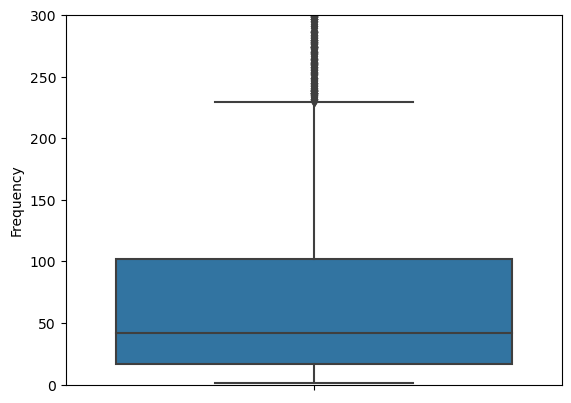

In [28]:
sns.boxplot(y='Frequency',data=RFM)
plt.ylim(0,300)

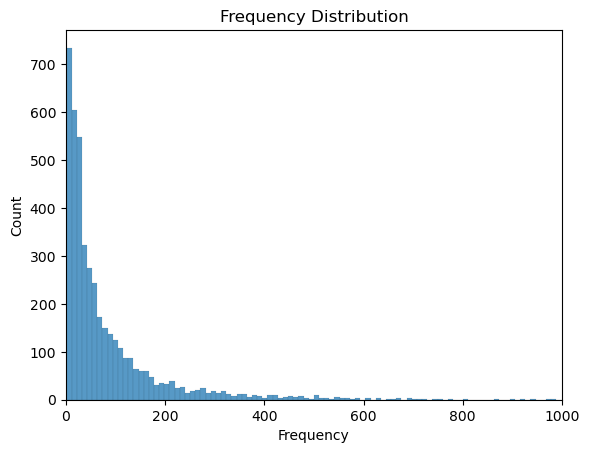

In [29]:
sns.histplot(data=RFM['Frequency'])
plt.title('Frequency Distribution')
plt.xlim(0,1000)
plt.show()

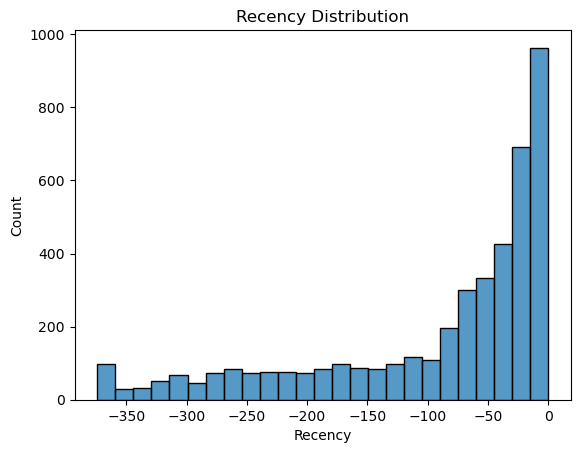

In [30]:
sns.histplot(data=RFM['Recency'])
plt.title('Recency Distribution')

plt.show()

## Calculate Monetary Value

In [31]:
#check monetary values
data.groupby('CustomerID').SaleValue.sum()

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
          ...   
18280     180.60
18281      80.82
18282     176.60
18283    2094.88
18287    1837.28
Name: SaleValue, Length: 4372, dtype: float64

In [32]:
data.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [33]:
import numpy as np

In [34]:
# getting aggregate values for SaleValue by Country
data.groupby('Country')['SaleValue'].agg([np.sum, np.mean, np.max, np.min])

,sum,mean,amax,amin
Country,,,,
Australia,137077.270,108.877895,1718.40,-425.00
Austria,10154.320,25.322494,360.00,-21.25
Bahrain,548.400,32.258824,120.00,11.60
Belgium,40910.960,19.773301,165.00,-19.95
Brazil,1143.600,35.737500,175.20,15.00
Canada,3666.380,24.280662,550.94,2.50
Channel Islands,20086.290,26.499063,408.00,-293.00
Cyprus,12946.290,20.813971,320.69,-320.69
Czech Republic,707.720,23.590667,70.80,-35.76


In [35]:
data.groupby([data.SaleValue==0]).CustomerID.value_counts()

SaleValue  CustomerID
False      17841         7983
           14911         5901
           14096         5128
           12748         4641
           14606         2782
                         ... 
True       16560            1
           16818            1
           17560            1
           17667            1
           18059            1
Name: CustomerID, Length: 4402, dtype: int64

In [36]:
#merge monetary value series into RFM dataframe
RFM = RFM.merge(data.groupby('CustomerID').SaleValue.sum().rename('Monetary'),on='CustomerID')

RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,-326,2,0.00
1,12347,-2,182,4310.00
2,12348,-75,31,1797.24
3,12349,-19,73,1757.55
4,12350,-310,17,334.40


In [37]:
#why do some people have monetary values of 0
#check with a sample
data[data.CustomerID=='12346']

#cucstomers who made returns

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleValue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6


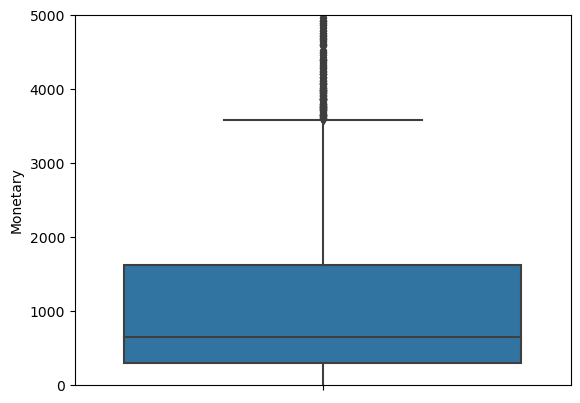

In [38]:
sns.boxplot(y='Monetary',data=RFM)

plt.ylim(0,5000)
plt.show()

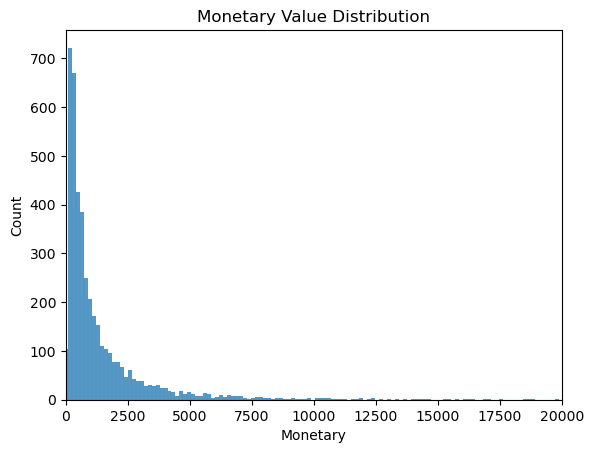

In [39]:
sns.histplot(data=RFM['Monetary'])
plt.title('Monetary Value Distribution')
plt.xlim(0,20000)
plt.show()

## Clustering with KMeans

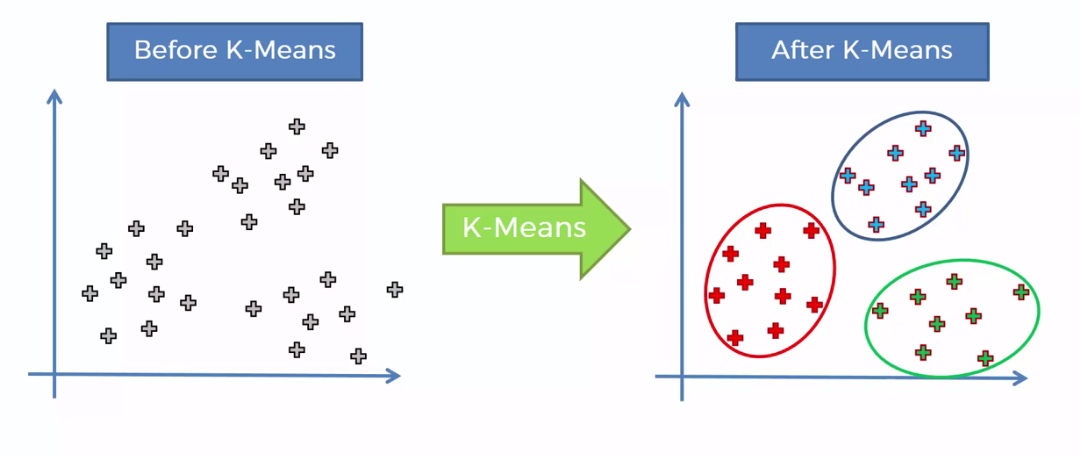

In [40]:
#let's set up KMeans to create 5 clusters
kmeans = KMeans(n_clusters=5,random_state=1)

In [41]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    '''
    This function is used to create a consistent order for the cluster numbers 
    that will be the output of the KMeans prediction.
    
    Parameters:
    cluster_field_name: str, name to be assigned to the cluster we are predicting for
    target_field_name: str, name of the column we're clustering 
    df: DataFrame, source of the data where prediction is to be done
    ascending: bool, order of cluster numbers
    '''
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

### Recency Clusters

In [42]:
#fit the model
kmeans.fit(RFM[['Recency']])

KMeans(n_clusters=5, random_state=1)

In [43]:
#predict clusters
recency_labels = kmeans.predict(RFM[['Recency']])

In [44]:
#add clusters to our dataframe
RFM['Recency_Score'] = recency_labels

In [45]:
#reorder clusters to be sequential
RFM = order_cluster('Recency_Score', 'Recency',RFM,True)

In [46]:
#view summary statistics
RFM.groupby('Recency_Score').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Score,,,,,,,,
0,303.0,-336.283828,26.971753,-374.0,-365.0,-331.0,-312.0,-292.0
1,442.0,-246.513575,25.619420,-291.0,-267.0,-247.0,-223.5,-202.0
2,532.0,-156.443609,25.568832,-201.0,-178.0,-156.0,-134.0,-114.0
3,1044.0,-70.369732,18.650422,-113.0,-82.0,-67.0,-54.0,-44.0
4,2051.0,-16.999025,11.969433,-43.0,-26.0,-16.0,-7.0,0.0


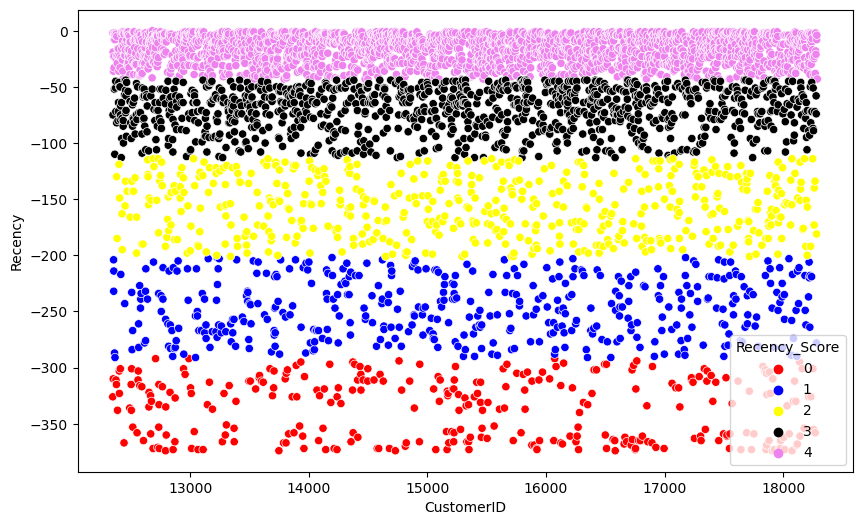

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Recency',hue='Recency_Score',data=RFM,palette=['red','blue','yellow','black','violet'])

plt.show()

### Frequency Clusters

In [48]:
#fit model
kmeans.fit(RFM[['Frequency']])

#predict clusters
frequency_labels = kmeans.predict(RFM[['Frequency']])

#save clusters in the data frame
RFM['Frequency_Score'] = frequency_labels

#order the clusters
RFM = order_cluster('Frequency_Score', 'Frequency',RFM,True)

#view details of clusters
RFM.groupby('Frequency_Score').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_Score,,,,,,,,
0,3277.0,34.337504,26.361525,1.0,13.00,28.0,51.0,101.0
1,866.0,170.146651,56.638151,102.0,123.00,154.0,208.0,312.0
2,203.0,456.541872,126.962074,313.0,356.50,420.0,517.5,898.0
3,22.0,1392.000000,510.778584,925.0,1064.75,1162.5,1607.0,2782.0
4,4.0,5914.000000,1473.845537,4642.0,5006.50,5515.5,6423.0,7983.0


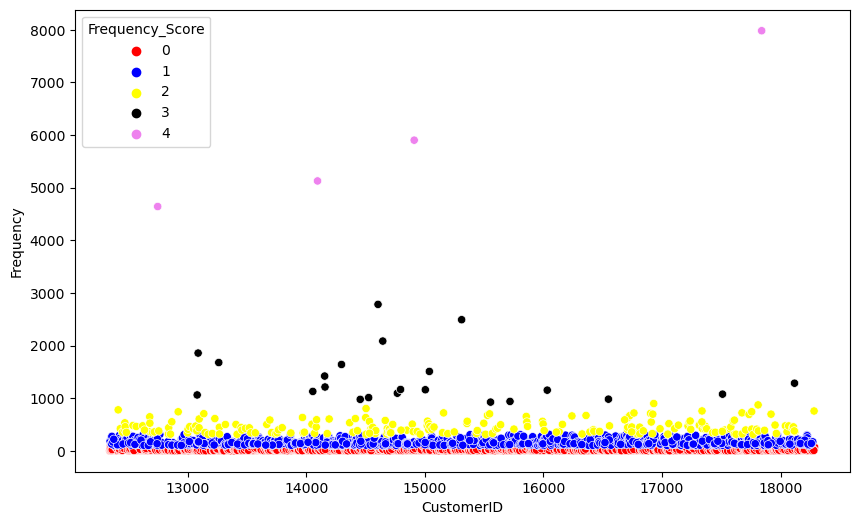

In [49]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Frequency',hue='Frequency_Score',data=RFM,palette=['red','blue','yellow','black','violet'])

plt.show()

### Monetary Value Clusters


In [50]:
#fit model
kmeans.fit(RFM[['Monetary']])
#predict clusters
monetary_labels = kmeans.predict(RFM[['Monetary']])
#save clusters in the data frame
RFM['Monetary_Score'] = monetary_labels
#order clusters
RFM = order_cluster('Monetary_Score', 'Monetary',RFM,True)
#view details of clusters
RFM.groupby('Monetary_Score').Monetary.describe()

,count,mean,std,min,25%,50%,75%,max
Monetary_Score,,,,,,,,
0,4073.0,948.451054,968.718422,-4287.63,271.8500,594.900,1308.4800,4531.34
1,265.0,8115.962038,3762.434618,4582.64,5423.1500,6748.400,9623.3500,21535.90
2,27.0,40928.794815,13322.664031,25748.35,28865.4900,33805.690,52287.2800,65892.08
3,5.0,129057.952000,36658.292209,88125.38,113384.1400,123725.450,132572.6200,187482.17
4,2.0,267963.755000,16299.186073,256438.49,262201.1225,267963.755,273726.3875,279489.02


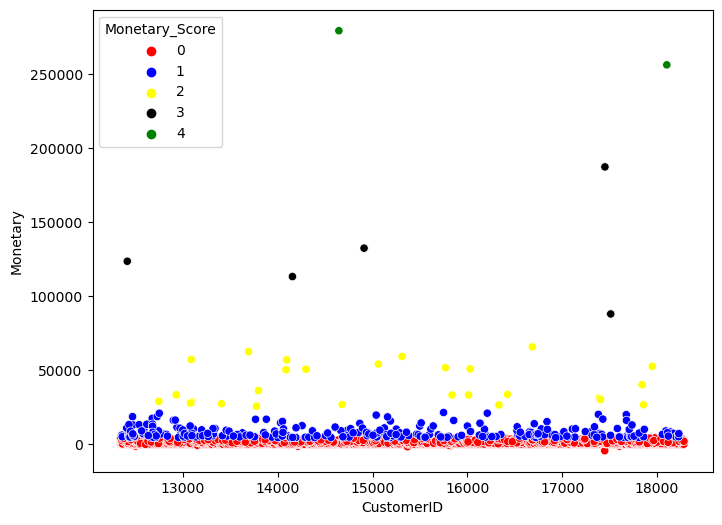

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Monetary',hue='Monetary_Score',data=RFM,palette=['red','blue','yellow','black','green'])

plt.show()

## Calculate Overall RFM Score

In [52]:
#create a sum of the scores 
#use sum(axis=1) to sum horizontally

RFM['Overall_Score'] = RFM[['Recency_Score','Frequency_Score','Monetary_Score']].sum(axis=1)
RFM.head(3)

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score
0,12346,-326,2,0.0,0,0,0,0
1,12350,-310,17,334.4,0,0,0,0
2,12373,-311,14,364.6,0,0,0,0


In [53]:
#check distribution of scores
RFM.Overall_Score.value_counts()

4     1318
3      916
5      567
2      495
1      438
0      295
6      205
7      103
8       21
10       6
9        6
11       2
Name: Overall_Score, dtype: int64

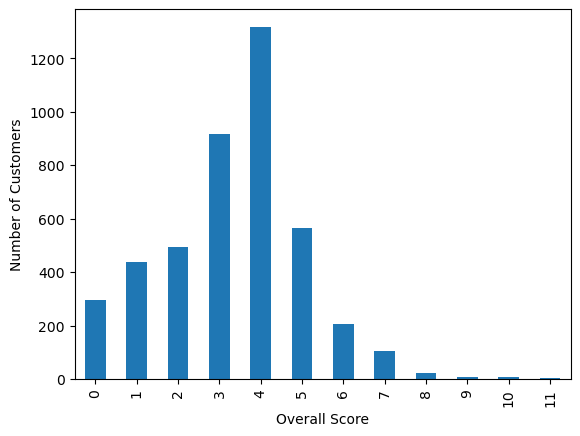

In [54]:
RFM.Overall_Score.value_counts().sort_index().plot.bar()
plt.ylabel('Number of Customers')
plt.xlabel('Overall Score')

plt.show()

In [55]:
RFM.groupby('Overall_Score').Monetary.describe()

,count,mean,std,min,25%,50%,75%,max
Overall_Score,,,,,,,,
0,295.0,283.426576,352.479252,-1192.20,120.1250,216.760,364.9350,2661.24
1,438.0,417.695685,482.419071,-141.48,162.4000,298.835,463.6575,4464.10
2,495.0,597.067699,1150.962454,-4287.63,195.3200,363.650,704.2100,21535.90
3,916.0,776.044828,853.248032,-1165.30,286.5275,535.955,1000.7450,9861.38
4,1318.0,989.362937,948.979302,-17.45,342.7000,695.230,1319.5850,11581.80
5,567.0,2409.891252,1648.306158,272.44,1322.7550,2144.530,3085.4850,12393.70
6,205.0,6004.876488,5443.288889,1052.55,3095.0400,4788.770,6336.2900,52750.84
7,103.0,11587.752136,10125.943650,3047.63,6222.7750,8234.800,12414.3700,65892.08
8,21.0,20418.507143,18054.444607,4678.30,7454.0700,10641.600,28658.8800,62653.10


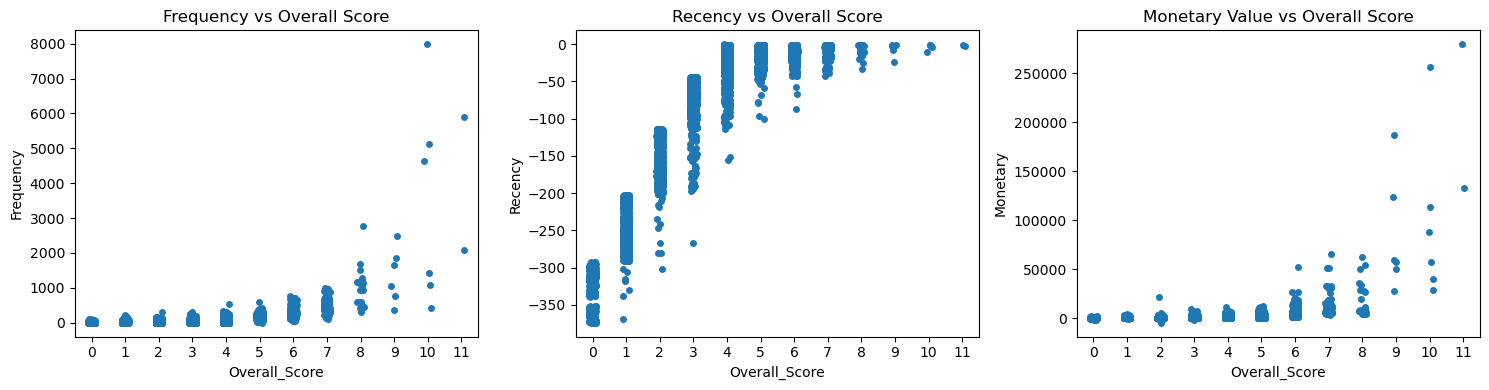

In [56]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0] = sns.stripplot(y='Frequency',x='Overall_Score',data = RFM, ax=ax[0])
ax[0].set_title('Frequency vs Overall Score')

ax[1] = sns.stripplot(y='Recency',x='Overall_Score',data = RFM, ax=ax[1])
ax[1].set_title('Recency vs Overall Score')

ax[2] = sns.stripplot(y='Monetary',x='Overall_Score',data = RFM, ax=ax[2])
ax[2].set_title('Monetary Value vs Overall Score')

plt.tight_layout()
plt.show()

### Assign Segments?

In [57]:
#assign segments
RFM['Segment'] = 'Low Value'
RFM.loc[RFM.Overall_Score>3,'Segment'] = 'Mid Value'
RFM.loc[RFM.Overall_Score>7,'Segment'] = 'High Value'

In [58]:
RFM.Segment.value_counts()

Mid Value     2193
Low Value     2144
High Value      35
Name: Segment, dtype: int64

In [60]:
#what are the records in one of the scores like
RFM[RFM.Overall_Score==2]


,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
2757,12383,-185,100,1839.31,2,0,0,2,Low Value
2758,12399,-119,59,1108.65,2,0,0,2,Low Value
2759,12405,-149,54,1710.39,2,0,0,2,Low Value
2760,12424,-163,30,1760.96,2,0,0,2,Low Value
2761,12426,-195,30,582.73,2,0,0,2,Low Value
...,...,...,...,...,...,...,...,...,...
3930,14670,-280,132,411.53,1,1,0,2,Low Value
3931,15235,-218,143,2247.51,1,1,0,2,Low Value
3932,17504,-206,140,2745.28,1,1,0,2,Low Value
4101,15749,-235,15,21535.90,1,0,1,2,Low Value


In [61]:
#check one person
RFM[RFM.CustomerID=='12346']

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
0,12346,-326,2,0.0,0,0,0,0,Low Value


In [62]:
#why do we have records where the total monetary value is negative.
data[data.CustomerID.isin(RFM[RFM.Monetary<0].CustomerID.to_list())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleValue
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom,-41.40
...,...,...,...,...,...,...,...,...,...
411728,C572228,22113,GREY HEART HOT WATER BOTTLE,-5,2011-10-21 14:03:00,3.75,15728,United Kingdom,-18.75
411729,C572228,22112,CHOCOLATE HOT WATER BOTTLE,-17,2011-10-21 14:03:00,4.25,15728,United Kingdom,-72.25
411730,C572228,22111,SCOTTIE DOG HOT WATER BOTTLE,-10,2011-10-21 14:03:00,3.45,15728,United Kingdom,-34.50
419485,572832,M,Manual,1,2011-10-26 11:40:00,1.00,16454,United Kingdom,1.00


Campaigns can be targeted to each customer segement depending on what is determined appropriate by the business stakeholders

# Further Study: Optimal Number of Clusters

## Elbow Method

In [63]:
from scipy.spatial.distance import cdist
import numpy as np

In [64]:
#to apply the elbow method to determine number of clusters
#recency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Recency']])
    clfmodel_pred = clfmodel.predict(RFM[['Recency']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Recency']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Recency']].shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Recency')

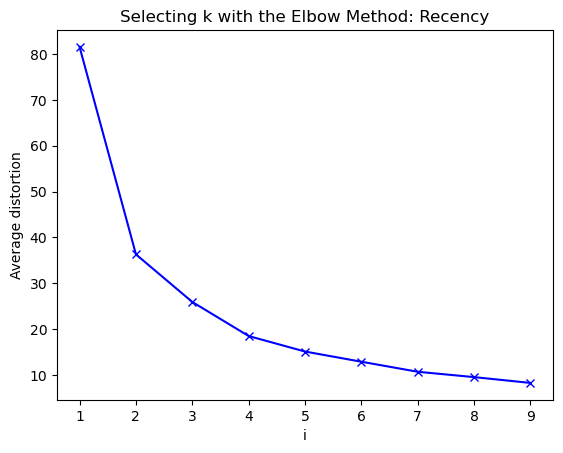

In [65]:
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Recency')

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Frequency')

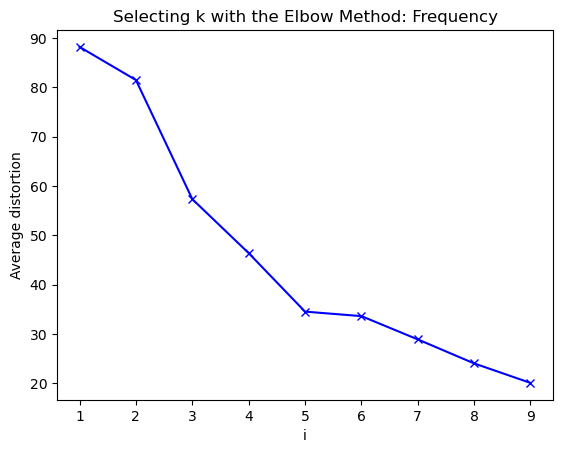

In [66]:
#to apply the elbow method to determine number of clusters
#frequency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Frequency']])
    clfmodel_pred = clfmodel.predict(RFM[['Frequency']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Frequency']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Frequency']].shape[0])
    
    
    
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Frequency')    

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Monetary')

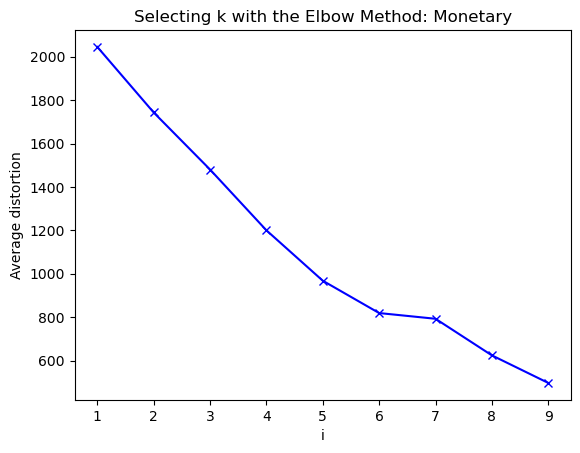

In [67]:
#to apply the elbow method to determine number of clusters
#recency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Monetary']])
    clfmodel_pred = clfmodel.predict(RFM[['Monetary']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Monetary']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Monetary']].shape[0])
    
    
#plot to find elbow    
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Monetary')    

## Silhouette Method

In [68]:
from sklearn.metrics import silhouette_score

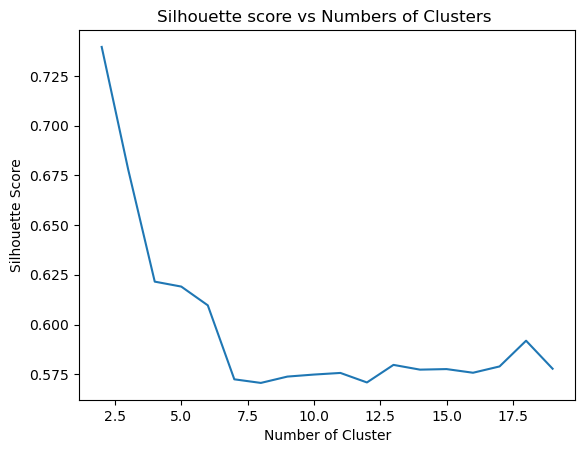

Optimal number :
2


In [69]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Recency']])
    predict = model.predict(RFM[['Recency']])
    silhouette_score(RFM[['Recency']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Recency']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)

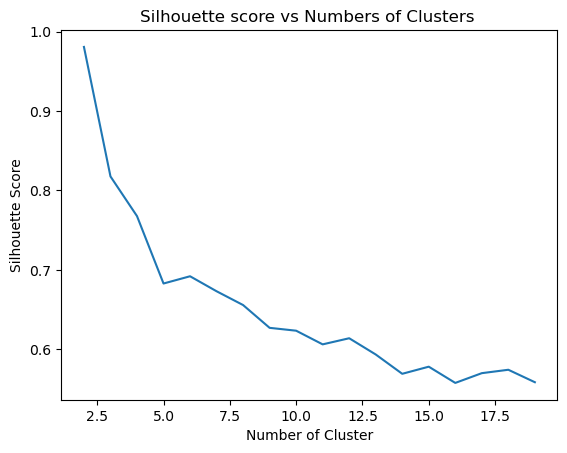

Optimal number :
2


In [70]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Frequency']])
    predict = model.predict(RFM[['Frequency']])
    silhouette_score(RFM[['Frequency']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Frequency']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)

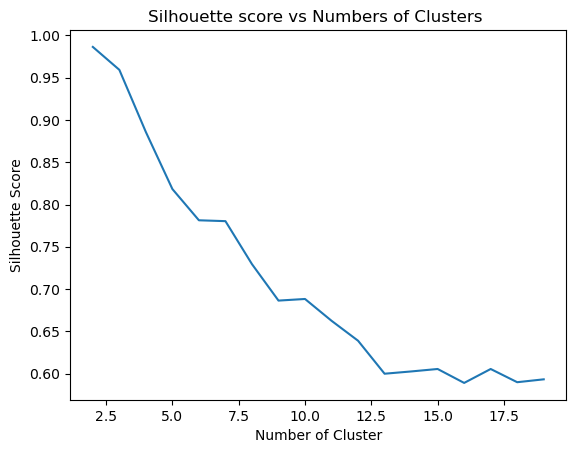

Optimal number :
2


In [71]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Monetary']])
    predict = model.predict(RFM[['Monetary']])
    silhouette_score(RFM[['Monetary']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Monetary']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)